Attempting to load: student_performance_data.csv
Dataset loaded successfully with shape: (1000, 14)

=== Data Quality Report ===
Total rows: 1000
Total columns: 14
Duplicate rows: 0 (0.00%)
Columns with missing values: 2
Columns with potential outliers: 5

Generating distribution visualizations...


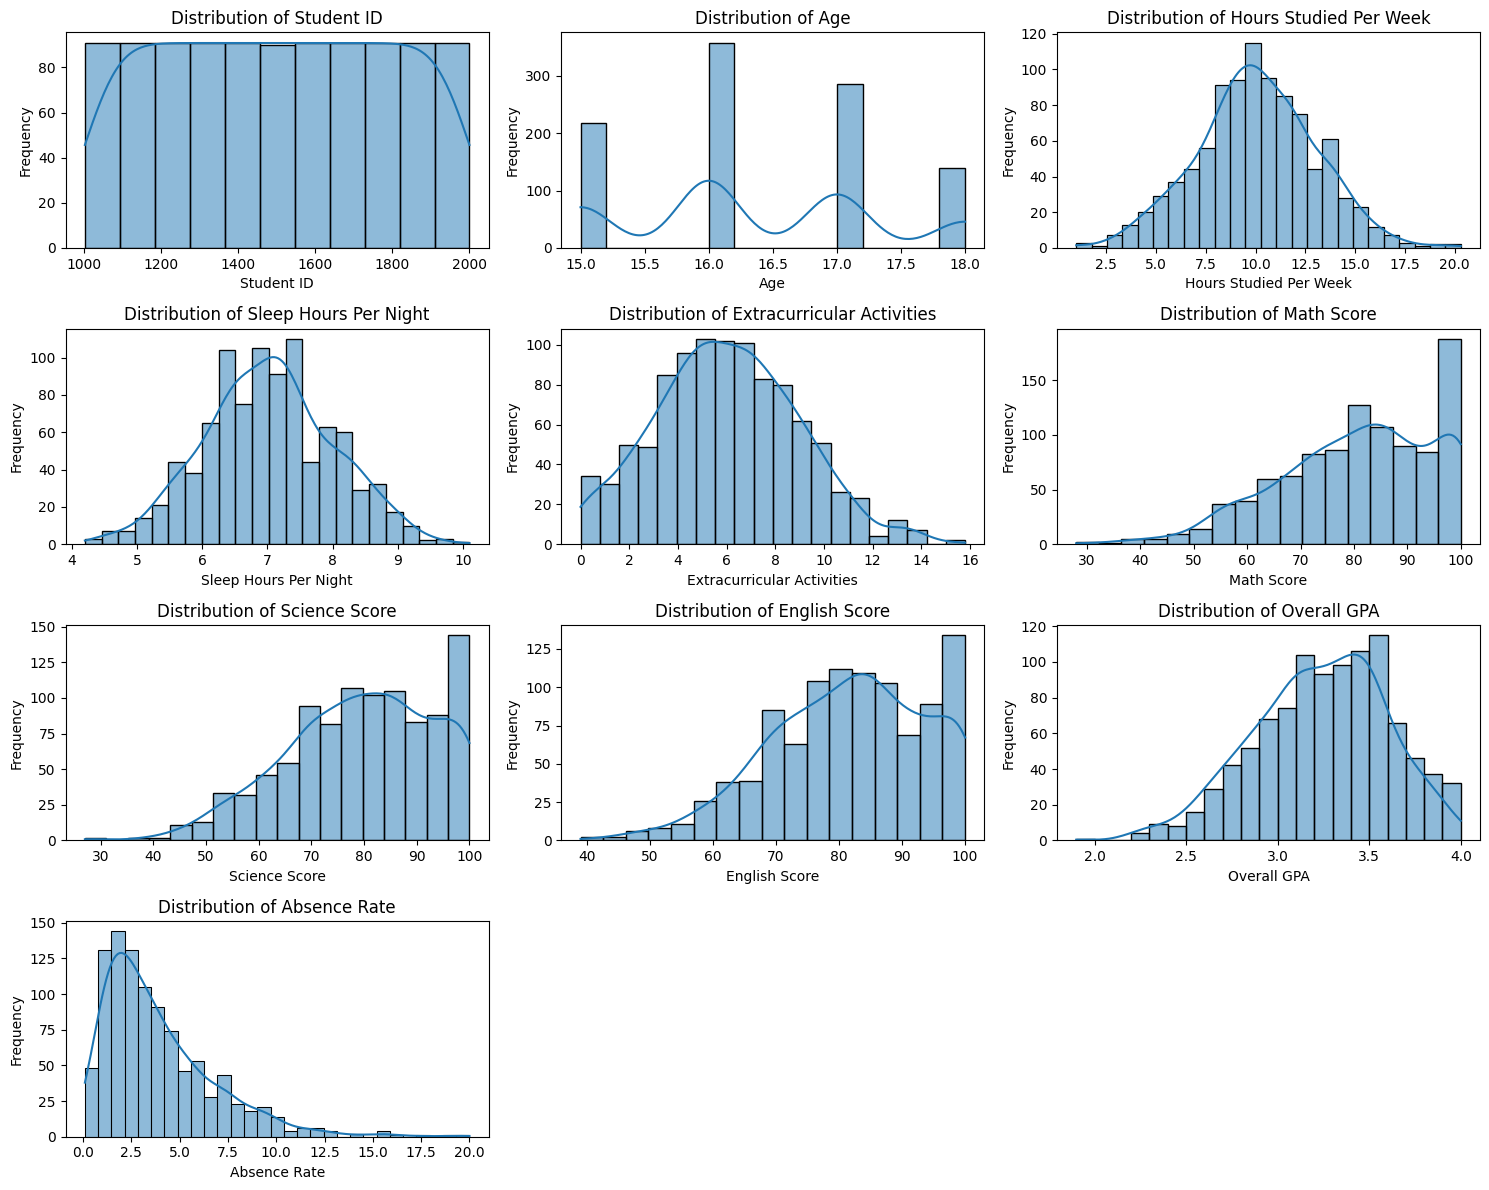

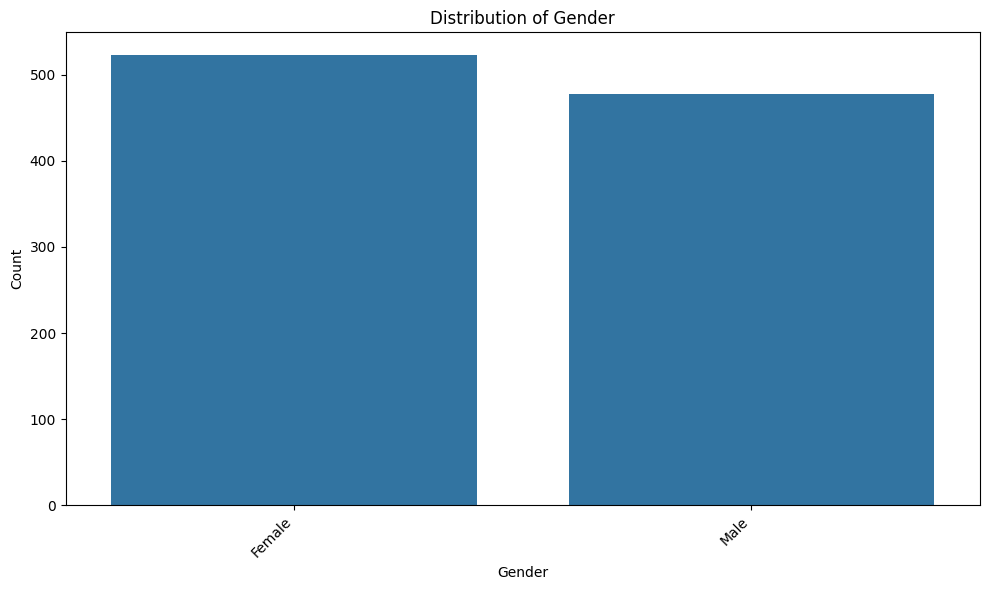

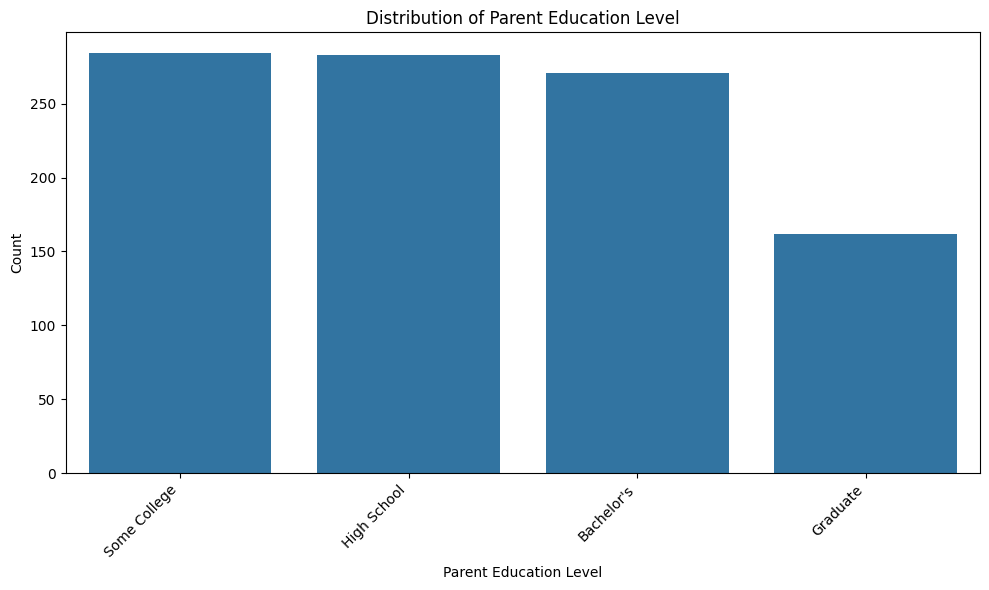

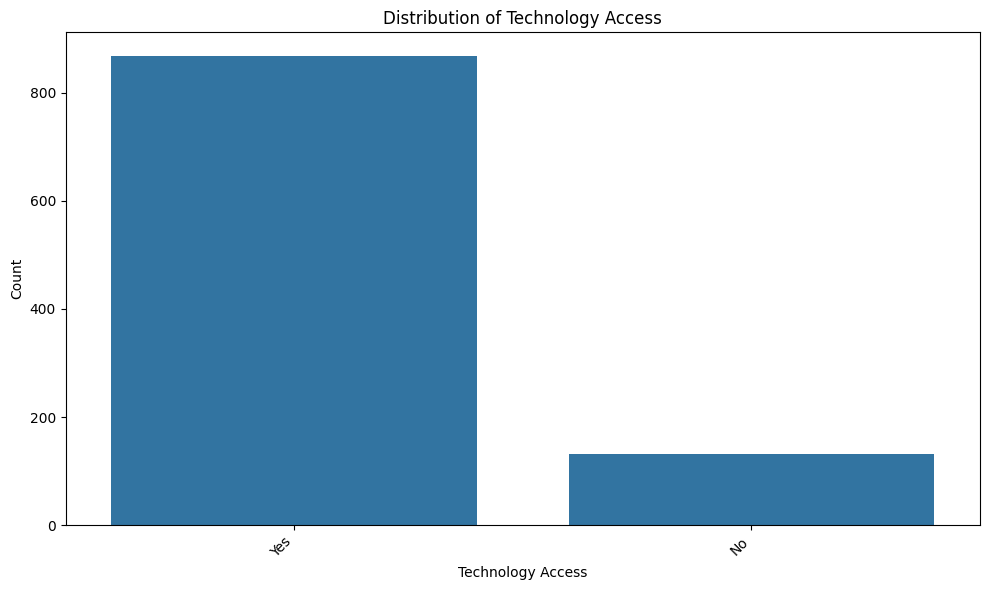

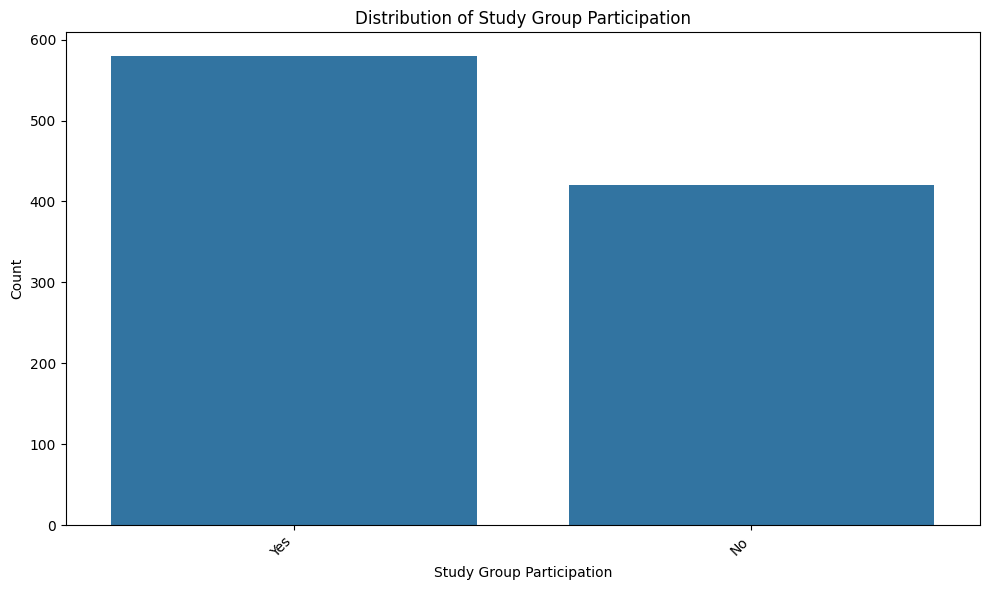

/tmp/ipykernel_2676/3701681743.py:190: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df[col].fillna(median_val, inplace=True)
/tmp/ipykernel_2676/3701681743.py:190: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Starting data cleaning process...
Removed 0 duplicate rows.
Imputed 5.20% missing values in 'Hours Studied Per Week' with median: 10.0
Imputed 5.50% missing values in 'Sleep Hours Per Night' with median: 7.0
Flagged 4 potential outliers in 'Sleep Hours Per Night'
Flagged 4 potential outliers in 'Math Score'
Flagged 4 potential outliers in 'Science Score'
Flagged 4 potential outliers in 'English Score'
Flagged 5 potential outliers in 'Overall GPA'
Data cleaning completed!

=== Before vs. After Cleaning ===
Original shape: (1000, 14)
Cleaned shape: (1000, 19)

Missing values before:
Student ID                     0
Gender                         0
Age                            0
Parent Education Level         0
Hours Studied Per Week        52
Sleep Hours Per Night         55
Extracurricular Activities     0
Math Score                     0
Science Score                  0
English Score                  0
Overall GPA                    0
Absence Rate                   0
Technology Acces

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_dataset(file_path):
    """
    Load a dataset from a file.
    
    Parameters:
    file_path (str): Path to the dataset file.
    
    Returns:
    DataFrame: The loaded dataset, or None if loading failed.
    """
    try:
        # Strip whitespace and convert to lowercase for more reliable checking
        clean_path = file_path.strip().lower()
        
        if clean_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        elif clean_path.endswith(('.xls', '.xlsx')):
            df = pd.read_excel(file_path)
        elif clean_path.endswith('.txt'):
            # Try to load as a CSV with different delimiters
            try:
                df = pd.read_csv(file_path, sep=',')
            except:
                try:
                    df = pd.read_csv(file_path, sep='\t')
                except:
                    try:
                        df = pd.read_csv(file_path, sep=';')
                    except:
                        print(f"Could not determine delimiter for text file. Please specify the format manually.")
                        return None
        else:
            print(f"Unsupported file format. Please provide a CSV, Excel, or TXT file.")
            print(f"If your file is in a supported format but has a different extension, please rename it.")
            return None
        
        print(f"Dataset loaded successfully with shape: {df.shape}")
        return df
    
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

def check_data_quality(df):
    """
    Check the quality of a dataset, identifying duplicates, missing values, and potential outliers.
    
    Parameters:
    df (DataFrame): The dataset to check.
    
    Returns:
    dict: A report of data quality issues.
    """
    quality_report = {
        'duplicates': {},
        'missing_values': {'count': {}, 'percentage': {}},
        'potential_outliers': {}
    }
    
    # Check for duplicates
    duplicates = df.duplicated()
    quality_report['duplicates']['count'] = duplicates.sum()
    quality_report['duplicates']['percentage'] = (duplicates.sum() / len(df)) * 100
    
    # Check for missing values
    for col in df.columns:
        missing = df[col].isnull()
        quality_report['missing_values']['count'][col] = missing.sum()
        quality_report['missing_values']['percentage'][col] = (missing.sum() / len(df)) * 100
    
    # Check for potential outliers (using IQR method) for numeric columns
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        # Skip columns with too many unique values (likely IDs or continuous values)
        if df[col].nunique() > 100:
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_count = outliers.sum()
        outlier_percentage = (outlier_count / len(df)) * 100
        
        if outlier_count > 0:
            quality_report['potential_outliers'][col] = {
                'count': outlier_count,
                'percentage': outlier_percentage,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
    
    return quality_report

def visualize_distributions(df, n_cols=3):
    """
    Create histograms for numerical features and bar plots for categorical features.
    
    Parameters:
    df (DataFrame): The dataset to visualize.
    n_cols (int): Number of columns in the subplot grid.
    """
    # Separate numerical and categorical columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Visualize numerical columns
    if len(num_cols) > 0:
        n_rows = (len(num_cols) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
        axes = axes.flatten() if n_rows * n_cols > 1 else [axes]
        
        for i, col in enumerate(num_cols):
            if i < len(axes):
                sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
                axes[i].set_title(f'Distribution of {col}')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Frequency')
        
        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # Visualize categorical columns
    if len(cat_cols) > 0:
        for col in cat_cols:
            plt.figure(figsize=(10, 6))
            value_counts = df[col].value_counts().sort_values(ascending=False)
            if len(value_counts) > 15:  # If too many categories, show only top 15
                value_counts = value_counts.iloc[:15]
                plt.title(f'Top 15 values in {col}')
            else:
                plt.title(f'Distribution of {col}')
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.xticks(rotation=45, ha='right')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()

def clean_dataset(df, quality_report=None):
    """
    Clean the dataset based on identified issues.
    
    Parameters:
    df (DataFrame): The dataset to clean.
    quality_report (dict, optional): Data quality report generated by check_data_quality.
    
    Returns:
    DataFrame: The cleaned dataset.
    """
    # Create a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Generate quality report if not provided
    if quality_report is None:
        quality_report = check_data_quality(df)
    
    print("Starting data cleaning process...")
    
    # Handle duplicates
    initial_rows = len(cleaned_df)
    cleaned_df = cleaned_df.drop_duplicates()
    rows_removed = initial_rows - len(cleaned_df)
    print(f"Removed {rows_removed} duplicate rows.")
    
    # Handle missing values
    for col in cleaned_df.columns:
        missing_pct = quality_report['missing_values']['percentage'][col]
        
        # If missing percentage is high (e.g., > 50%), consider dropping the column
        if missing_pct > 50:
            print(f"Column '{col}' has {missing_pct:.2f}% missing values. Consider dropping this column.")
        
        # For numeric columns, impute with median
        elif col in cleaned_df.select_dtypes(include=['int64', 'float64']).columns:
            if missing_pct > 0:
                median_val = cleaned_df[col].median()
                cleaned_df[col].fillna(median_val, inplace=True)
                print(f"Imputed {missing_pct:.2f}% missing values in '{col}' with median: {median_val}")
        
        # For categorical columns, impute with mode
        elif col in cleaned_df.select_dtypes(include=['object', 'category']).columns:
            if missing_pct > 0:
                mode_val = cleaned_df[col].mode()[0]
                cleaned_df[col].fillna(mode_val, inplace=True)
                print(f"Imputed {missing_pct:.2f}% missing values in '{col}' with mode: {mode_val}")
    
    # Handle outliers (using a conservative approach - just flagging, not removing)
    outlier_flags = {}
    for col, outlier_info in quality_report['potential_outliers'].items():
        if outlier_info['percentage'] > 0:
            lower_bound = outlier_info['lower_bound']
            upper_bound = outlier_info['upper_bound']
            outlier_flags[f'{col}_outlier'] = (
                (cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)
            )
            print(f"Flagged {outlier_info['count']} potential outliers in '{col}'")
    
    # Add outlier flags to the dataframe
    if outlier_flags:
        for col, flag in outlier_flags.items():
            cleaned_df[col] = flag
    
    # Convert data types where appropriate
    for col in cleaned_df.columns:
        # Try to convert object columns to datetime if they look like dates
        if cleaned_df[col].dtype == 'object':
            try:
                # Check if this might be a date column
                if cleaned_df[col].str.contains('-|/|:').any():
                    cleaned_df[col] = pd.to_datetime(cleaned_df[col], errors='ignore')
                    if cleaned_df[col].dtype.kind == 'M':  # If conversion was successful
                        print(f"Converted '{col}' to datetime.")
            except:
                pass
        
        # Try to convert string numeric columns to float
        if cleaned_df[col].dtype == 'object':
            try:
                # Remove currency symbols and commas if present
                temp_series = cleaned_df[col].str.replace('[$,]', '', regex=True)
                # Check if all non-NA values can be converted to float
                if pd.to_numeric(temp_series, errors='coerce').notna().all():
                    cleaned_df[col] = pd.to_numeric(temp_series)
                    print(f"Converted '{col}' to numeric.")
            except:
                pass
    
    print("Data cleaning completed!")
    
    return cleaned_df

def save_cleaned_dataset(df, output_path):
    """
    Save the cleaned dataset to a file.
    
    Parameters:
    df (DataFrame): The dataset to save.
    output_path (str): Path to save the cleaned dataset.
    
    Returns:
    bool: True if saved successfully, False otherwise.
    """
    try:
        if output_path.endswith('.csv'):
            df.to_csv(output_path, index=False)
        elif output_path.endswith(('.xls', '.xlsx')):
            df.to_excel(output_path, index=False)
        else:
            # Default to CSV
            output_path = output_path + '.csv' if not '.' in output_path else output_path.split('.')[0] + '.csv'
            df.to_csv(output_path, index=False)
        
        print(f"Cleaned dataset saved to: {output_path}")
        return True
    
    except Exception as e:
        print(f"Error saving cleaned dataset: {e}")
        return False

def main():
    # Use a fixed file path for the student performance data
    file_path = "student_performance_data.csv"
    print(f"Attempting to load: {file_path}")
    
    # Load the dataset
    try:
        # Try direct pandas loading to bypass our custom function
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully with shape: {df.shape}")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None
    
    # Check data quality
    quality_report = check_data_quality(df)
    
    # Print quality report summary
    print("\n=== Data Quality Report ===")
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}")
    print(f"Duplicate rows: {quality_report['duplicates']['count']} ({quality_report['duplicates']['percentage']:.2f}%)")
    
    # Count columns with missing values properly
    columns_with_missing = sum(1 for col, count in quality_report['missing_values']['count'].items() if count > 0)
    print(f"Columns with missing values: {columns_with_missing}")
    
    print(f"Columns with potential outliers: {len(quality_report['potential_outliers'])}")
    
    # Visualize data distributions
    print("\nGenerating distribution visualizations...")
    visualize_distributions(df)
    
    # Clean the dataset
    cleaned_df = clean_dataset(df, quality_report)
    
    # Compare before and after
    print("\n=== Before vs. After Cleaning ===")
    print(f"Original shape: {df.shape}")
    print(f"Cleaned shape: {cleaned_df.shape}")
    print("\nMissing values before:")
    print(df.isnull().sum())
    print("\nMissing values after:")
    print(cleaned_df.isnull().sum())
    
    # Ask whether to save the cleaned dataset
    save_option = input("\nDo you want to save the cleaned dataset? (yes/no): ").lower()
    if save_option in ['yes', 'y']:
        output_path = input("Enter the path to save the cleaned dataset: ")
        save_cleaned_dataset(cleaned_df, output_path)

if __name__ == "__main__":
    main()